In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [4]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new6', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new6', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new6', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new6', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [5]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [6]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [7]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [8]:
train_images.shape

(2913, 256, 256, 1)

In [9]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [10]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16')/256
test_images = test_images.astype('uint16')/256

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [11]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [12]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

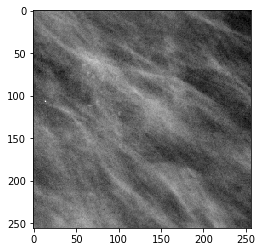

Label: [1. 0. 0. 0.]
[[[139.06640625 139.06640625 139.06640625]
  [134.77734375 134.77734375 134.77734375]
  [138.1796875  138.1796875  138.1796875 ]
  ...
  [ 97.765625    97.765625    97.765625  ]
  [101.75390625 101.75390625 101.75390625]
  [ 99.484375    99.484375    99.484375  ]]

 [[136.49609375 136.49609375 136.49609375]
  [138.25390625 138.25390625 138.25390625]
  [140.77734375 140.77734375 140.77734375]
  ...
  [102.28515625 102.28515625 102.28515625]
  [105.234375   105.234375   105.234375  ]
  [102.83984375 102.83984375 102.83984375]]

 [[136.4921875  136.4921875  136.4921875 ]
  [133.921875   133.921875   133.921875  ]
  [138.0703125  138.0703125  138.0703125 ]
  ...
  [101.265625   101.265625   101.265625  ]
  [102.12109375 102.12109375 102.12109375]
  [102.33203125 102.33203125 102.33203125]]

 ...

 [[151.6640625  151.6640625  151.6640625 ]
  [146.94140625 146.94140625 146.94140625]
  [146.92578125 146.92578125 146.92578125]
  ...
  [122.15625    122.15625    122.15625  

In [13]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 789

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

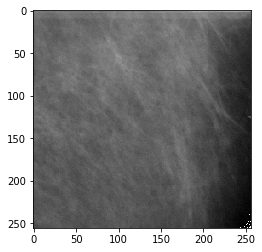

Label: [0. 1. 0. 0.]
[[[139.06640625 139.06640625 139.06640625]
  [134.77734375 134.77734375 134.77734375]
  [138.1796875  138.1796875  138.1796875 ]
  ...
  [ 97.765625    97.765625    97.765625  ]
  [101.75390625 101.75390625 101.75390625]
  [ 99.484375    99.484375    99.484375  ]]

 [[136.49609375 136.49609375 136.49609375]
  [138.25390625 138.25390625 138.25390625]
  [140.77734375 140.77734375 140.77734375]
  ...
  [102.28515625 102.28515625 102.28515625]
  [105.234375   105.234375   105.234375  ]
  [102.83984375 102.83984375 102.83984375]]

 [[136.4921875  136.4921875  136.4921875 ]
  [133.921875   133.921875   133.921875  ]
  [138.0703125  138.0703125  138.0703125 ]
  ...
  [101.265625   101.265625   101.265625  ]
  [102.12109375 102.12109375 102.12109375]
  [102.33203125 102.33203125 102.33203125]]

 ...

 [[151.6640625  151.6640625  151.6640625 ]
  [146.94140625 146.94140625 146.94140625]
  [146.92578125 146.92578125 146.92578125]
  ...
  [122.15625    122.15625    122.15625  

In [14]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 5

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(test_labels[idx]))

print(train_images[0])

In [22]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(1024, activation='relu'))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [23]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [24]:
vgg16_fe_drop_temp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 48,533,572
Trainable params: 33,818,884
Non-trainable params: 14,714,688
_________________________________

In [25]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [26]:
vgg16_fe_drop_128.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
_________________________________

In [27]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [28]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 11 steps, validate for 5 steps
Epoch 1/300
10/11 [==========================>...] - ETA: 1s - loss: 4.0825 - accuracy: 0.3325
Epoch 00001: val_loss improved from inf to 1.42856, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 23s 2s/step - loss: 3.8578 - accuracy: 0.3351 - val_loss: 1.4286 - val_accuracy: 0.3711
Epoch 2/300
10/11 [==========================>...] - ETA: 1s - loss: 1.4498 - accuracy: 0.4078
Epoch 00002: val_loss improved from 1.42856 to 1.23154, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 22s 2s/step - loss: 1.4319 - accuracy: 0.4091 - val_loss: 1.2315 - val_accuracy: 0.4433
Epoch 3/300
10/11 [==========================>...] - ETA: 1s - loss: 1.3188 - accuracy: 0.4563
Epoch 00003: val_loss improved from 1.23154 to 1.16067, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 1.3

Epoch 28/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9514 - accuracy: 0.5930
Epoch 00028: val_loss improved from 0.95300 to 0.93582, saving model to vgg16_fe_drop_128_4cl_best.h5
11/11 [==============================] - 21s 2s/step - loss: 0.9589 - accuracy: 0.5859 - val_loss: 0.9358 - val_accuracy: 0.5636
Epoch 29/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9674 - accuracy: 0.5903
Epoch 00029: val_loss did not improve from 0.93582
11/11 [==============================] - 20s 2s/step - loss: 0.9745 - accuracy: 0.5853 - val_loss: 0.9761 - val_accuracy: 0.5550
Epoch 30/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9764 - accuracy: 0.5695
Epoch 00030: val_loss did not improve from 0.93582
11/11 [==============================] - 22s 2s/step - loss: 0.9769 - accuracy: 0.5696 - val_loss: 0.9702 - val_accuracy: 0.5670
Epoch 31/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9607 - accuracy: 0.5844
Epoch 00031: val_loss did

Epoch 57/300
10/11 [==========================>...] - ETA: 1s - loss: 0.8975 - accuracy: 0.5988
Epoch 00057: val_loss did not improve from 0.89448
11/11 [==============================] - 21s 2s/step - loss: 0.8998 - accuracy: 0.6044 - val_loss: 0.9580 - val_accuracy: 0.5533
Epoch 58/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9353 - accuracy: 0.5992
Epoch 00058: val_loss did not improve from 0.89448
11/11 [==============================] - 22s 2s/step - loss: 0.9270 - accuracy: 0.6009 - val_loss: 0.9231 - val_accuracy: 0.5739
Epoch 59/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9022 - accuracy: 0.5971
Epoch 00059: val_loss did not improve from 0.89448
11/11 [==============================] - 20s 2s/step - loss: 0.8905 - accuracy: 0.6052 - val_loss: 0.9161 - val_accuracy: 0.5859
Epoch 60/300
10/11 [==========================>...] - ETA: 1s - loss: 0.9047 - accuracy: 0.6209
Epoch 00060: val_loss did not improve from 0.89448
11/11 [==================

In [29]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [30]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [31]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [32]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 76
Epoch [opt]: 46
Valid accuracy [end]: 0.5567
Valid accuracy [opt]: 0.5911
Test accuracy [end]:  0.5863
Test accuracy [opt]:  0.6000
Valid loss [end]: 0.9993
Valid loss [opt]: 0.8945
Test loss [end]:  0.9830
Test loss [opt]:  0.9268


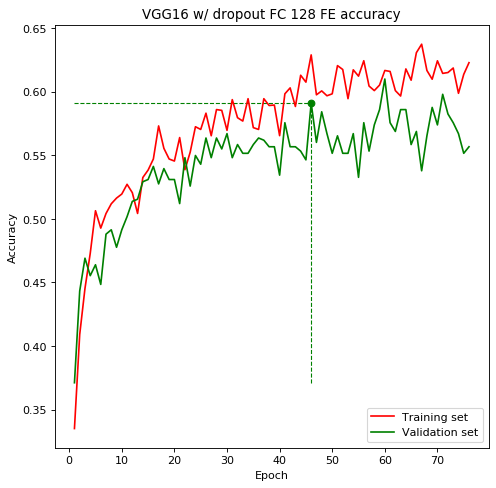

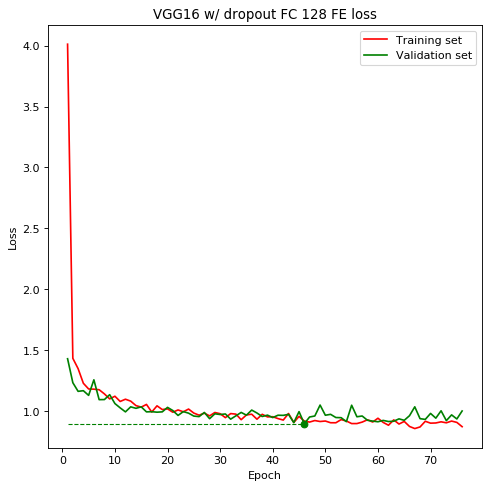

In [33]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [34]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 2.8361 - accuracy: 0.2887
Epoch 00001: val_loss improved from inf to 1.85000, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 32s 2s/step - loss: 2.8083 - accuracy: 0.2900 - val_loss: 1.8500 - val_accuracy: 0.3746
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 2.1092 - accuracy: 0.3718
Epoch 00002: val_loss improved from 1.85000 to 1.52685, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 2.0979 - accuracy: 0.3677 - val_loss: 1.5268 - val_accuracy: 0.4038
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.8491 - accuracy: 0.4022
Epoch 00003: val_loss improved from 1.52685 to 1.40407, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.8

19/19 [==============================] - 30s 2s/step - loss: 1.2283 - accuracy: 0.5019 - val_loss: 1.0729 - val_accuracy: 0.5000
Epoch 28/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1971 - accuracy: 0.5011
Epoch 00028: val_loss improved from 1.07288 to 1.05589, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1943 - accuracy: 0.5032 - val_loss: 1.0559 - val_accuracy: 0.4931
Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1889 - accuracy: 0.5030
Epoch 00029: val_loss did not improve from 1.05589
19/19 [==============================] - 29s 2s/step - loss: 1.1951 - accuracy: 0.5011 - val_loss: 1.1199 - val_accuracy: 0.4863
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2129 - accuracy: 0.4848
Epoch 00030: val_loss did not improve from 1.05589
19/19 [==============================] - 29s 2s/step - loss: 1.2091 - accuracy: 0.4895 - val_loss: 1.0797 - val_accuracy:

18/19 [===========================>..] - ETA: 1s - loss: 1.0807 - accuracy: 0.5402
Epoch 00056: val_loss improved from 1.02422 to 1.00667, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.0817 - accuracy: 0.5405 - val_loss: 1.0067 - val_accuracy: 0.5430
Epoch 57/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0823 - accuracy: 0.5247
Epoch 00057: val_loss did not improve from 1.00667
19/19 [==============================] - 29s 2s/step - loss: 1.0774 - accuracy: 0.5255 - val_loss: 1.0515 - val_accuracy: 0.4983
Epoch 58/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0965 - accuracy: 0.5266
Epoch 00058: val_loss did not improve from 1.00667
19/19 [==============================] - 29s 2s/step - loss: 1.0923 - accuracy: 0.5315 - val_loss: 1.0704 - val_accuracy: 0.5017
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1160 - accuracy: 0.5225
Epoch 00059: val_loss did not improve 

18/19 [===========================>..] - ETA: 1s - loss: 1.0312 - accuracy: 0.5542
Epoch 00085: val_loss did not improve from 0.98137
19/19 [==============================] - 29s 2s/step - loss: 1.0304 - accuracy: 0.5560 - val_loss: 1.0045 - val_accuracy: 0.5430
Epoch 86/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0384 - accuracy: 0.5452
Epoch 00086: val_loss improved from 0.98137 to 0.97541, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.0413 - accuracy: 0.5423 - val_loss: 0.9754 - val_accuracy: 0.5430
Epoch 87/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0376 - accuracy: 0.5520
Epoch 00087: val_loss did not improve from 0.97541
19/19 [==============================] - 29s 2s/step - loss: 1.0333 - accuracy: 0.5526 - val_loss: 1.0948 - val_accuracy: 0.5017
Epoch 88/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0248 - accuracy: 0.5506
Epoch 00088: val_loss did not improve 

18/19 [===========================>..] - ETA: 1s - loss: 0.9836 - accuracy: 0.5769
Epoch 00114: val_loss did not improve from 0.96836
19/19 [==============================] - 29s 2s/step - loss: 0.9842 - accuracy: 0.5766 - val_loss: 0.9800 - val_accuracy: 0.5447
Epoch 115/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0083 - accuracy: 0.5601
Epoch 00115: val_loss did not improve from 0.96836
19/19 [==============================] - 29s 2s/step - loss: 1.0052 - accuracy: 0.5616 - val_loss: 0.9913 - val_accuracy: 0.5344
Epoch 116/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9927 - accuracy: 0.5547
Epoch 00116: val_loss did not improve from 0.96836
19/19 [==============================] - 29s 2s/step - loss: 0.9921 - accuracy: 0.5568 - val_loss: 0.9937 - val_accuracy: 0.5447
Epoch 117/150
18/19 [===========================>..] - ETA: 1s - loss: 1.0057 - accuracy: 0.5493
Epoch 00117: val_loss did not improve from 0.96836
19/19 [============================

18/19 [===========================>..] - ETA: 1s - loss: 0.9826 - accuracy: 0.5647
Epoch 00143: val_loss did not improve from 0.92507
19/19 [==============================] - 29s 2s/step - loss: 0.9849 - accuracy: 0.5659 - val_loss: 0.9571 - val_accuracy: 0.5447
Epoch 144/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9770 - accuracy: 0.5611
Epoch 00144: val_loss did not improve from 0.92507
19/19 [==============================] - 29s 2s/step - loss: 0.9853 - accuracy: 0.5603 - val_loss: 0.9591 - val_accuracy: 0.5567
Epoch 145/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9750 - accuracy: 0.5683
Epoch 00145: val_loss did not improve from 0.92507
19/19 [==============================] - 29s 2s/step - loss: 0.9709 - accuracy: 0.5714 - val_loss: 0.9613 - val_accuracy: 0.5447
Epoch 146/150
18/19 [===========================>..] - ETA: 1s - loss: 0.9742 - accuracy: 0.5724
Epoch 00146: val_loss did not improve from 0.92507
19/19 [============================

In [36]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [37]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 150
Epoch [opt]: 135
Valid accuracy [end]: 0.5619
Valid accuracy [opt]: 0.5481
Test accuracy [end]:  0.5969
Test accuracy [opt]:  0.5939
Valid loss [end]: 0.9574
Valid loss [opt]: 0.9251
Test loss [end]:  0.9053
Test loss [opt]:  0.9123


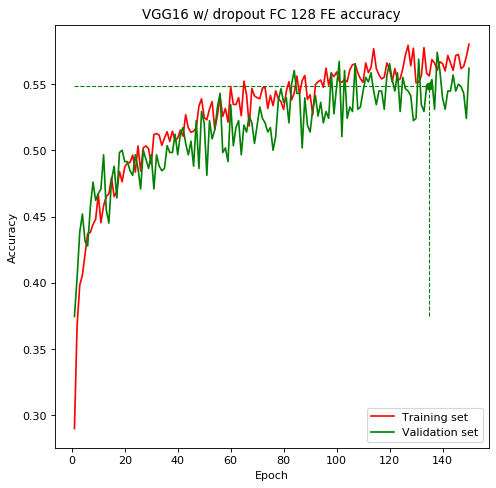

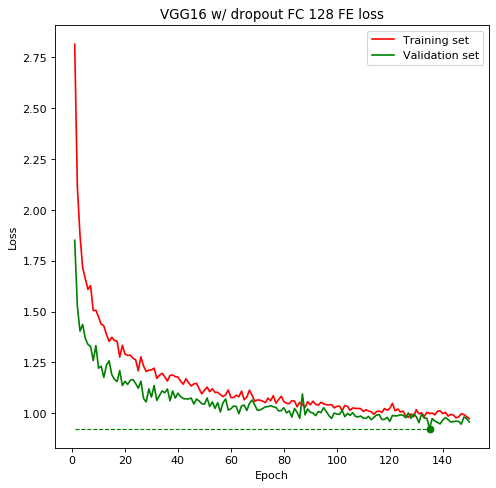

In [38]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [39]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 33,687,172
Non-trainable params: 14,714,688
_________________________________

In [40]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 48,401,860
Trainable params: 36,046,980
Non-trainable params: 12,354,880
_________________________________

In [16]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [17]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/300
4/5 [=======================>......] - ETA: 2s - loss: 0.8374 - accuracy: 0.5748
Epoch 00001: val_loss improved from inf to 0.71542, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [==============================] - 16s 3s/step - loss: 0.8207 - accuracy: 0.5721 - val_loss: 0.7154 - val_accuracy: 0.6920
Epoch 2/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6637 - accuracy: 0.6346
Epoch 00002: val_loss improved from 0.71542 to 0.62596, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.6596 - accuracy: 0.6376 - val_loss: 0.6260 - val_accuracy: 0.6304
Epoch 3/300
4/5 [=======================>......] - ETA: 1s - loss: 0.6333 - accuracy: 0.6410
Epoch 00003: val_loss improved from 0.62596 to 0.59939, saving model to vgg16_ft_1layer_4cl_best.h5
5/5 [

Epoch 28/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5564 - accuracy: 0.7305
Epoch 00028: val_loss did not improve from 0.54474
5/5 [==============================] - 10s 2s/step - loss: 0.5654 - accuracy: 0.7172 - val_loss: 0.6742 - val_accuracy: 0.6377
Epoch 29/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5876 - accuracy: 0.6895
Epoch 00029: val_loss did not improve from 0.54474
5/5 [==============================] - 11s 2s/step - loss: 0.5757 - accuracy: 0.6922 - val_loss: 0.5814 - val_accuracy: 0.6667
Epoch 30/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5698 - accuracy: 0.6836
Epoch 00030: val_loss did not improve from 0.54474
5/5 [==============================] - 11s 2s/step - loss: 0.5767 - accuracy: 0.6779 - val_loss: 0.5781 - val_accuracy: 0.7391
Epoch 31/300
4/5 [=======================>......] - ETA: 1s - loss: 0.5783 - accuracy: 0.7009
Epoch 00031: val_loss did not improve from 0.54474
5/5 [==============================] - 

In [18]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [19]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 55
Epoch [opt]: 25
Valid accuracy [end]: 0.6413
Valid accuracy [opt]: 0.7210
Test accuracy [end]:  0.6603
Test accuracy [opt]:  0.7404
Valid loss [end]: 0.6605
Valid loss [opt]: 0.5447
Test loss [end]:  0.6225
Test loss [opt]:  0.5664


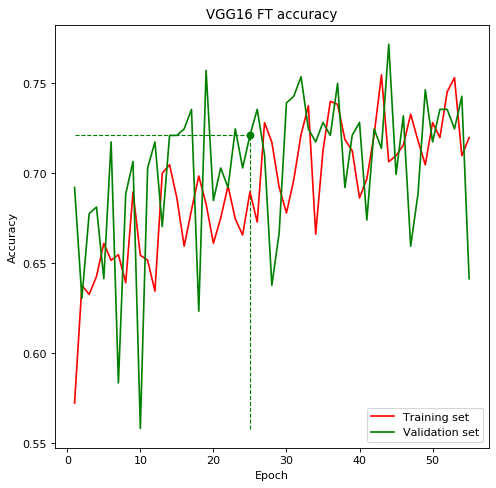

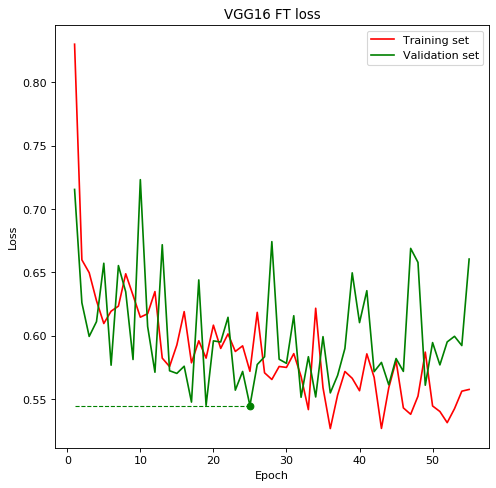

In [20]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [21]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 38,406,530
Non-trainable params: 9,995,072
__________________________________

In [22]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [23]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5484 - accuracy: 0.7030
Epoch 00001: val_loss improved from inf to 0.53765, saving model to vgg16_ft_2layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5624 - accuracy: 0.6913 - val_loss: 0.5377 - val_accuracy: 0.7428
Epoch 2/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5649 - accuracy: 0.7009
Epoch 00002: val_loss did not improve from 0.53765
5/5 [==============================] - 10s 2s/step - loss: 0.5648 - accuracy: 0.7013 - val_loss: 0.5994 - val_accuracy: 0.7283
Epoch 3/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5421 - accuracy: 0.7158
Epoch 00003: val_loss did not improve from 0.53765
5/5 [==============================] - 10s 2s/step - loss: 0.5458 - accuracy: 0.7131 - val_loss: 0.5595 - val_accuracy: 0.7717
Epoch 4/200
4/5 [=======================>......] - E

Epoch 30/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5498 - accuracy: 0.7031
Epoch 00030: val_loss did not improve from 0.50752
5/5 [==============================] - 11s 2s/step - loss: 0.5529 - accuracy: 0.7047 - val_loss: 0.5945 - val_accuracy: 0.7138
Epoch 31/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5681 - accuracy: 0.7179
Epoch 00031: val_loss did not improve from 0.50752
5/5 [==============================] - 11s 2s/step - loss: 0.5684 - accuracy: 0.7148 - val_loss: 0.5757 - val_accuracy: 0.7681
Epoch 32/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5530 - accuracy: 0.7207
Epoch 00032: val_loss did not improve from 0.50752
5/5 [==============================] - 10s 2s/step - loss: 0.5581 - accuracy: 0.7094 - val_loss: 0.6169 - val_accuracy: 0.7138
Epoch 33/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5346 - accuracy: 0.7137
Epoch 00033: val_loss did not improve from 0.50752
5/5 [==============================] - 

In [24]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [25]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 49
Epoch [opt]: 19
Valid accuracy [end]: 0.7138
Valid accuracy [opt]: 0.7790
Test accuracy [end]:  0.7340
Test accuracy [opt]:  0.7436
Valid loss [end]: 0.5540
Valid loss [opt]: 0.5075
Test loss [end]:  0.5538
Test loss [opt]:  0.5594


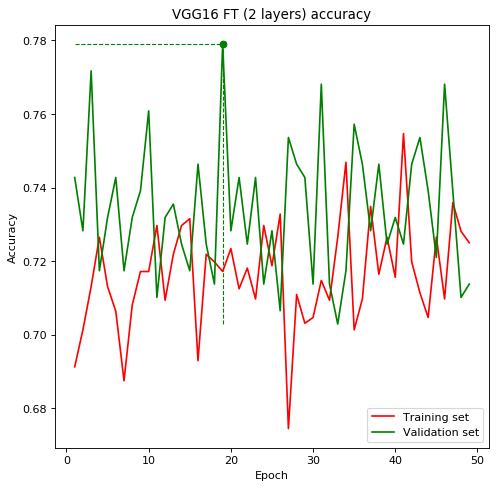

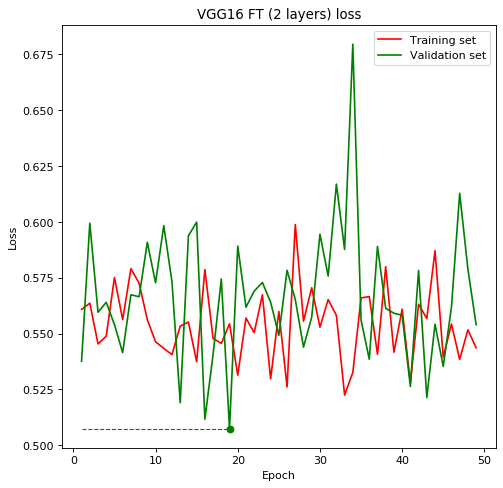

In [26]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [27]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_6 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
Total params: 48,401,602
Trainable params: 40,766,338
Non-trainable params: 7,635,264
__________________________________

In [28]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [29]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 256,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 5 steps, validate for 3 steps
Epoch 1/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5760 - accuracy: 0.7158
Epoch 00001: val_loss improved from inf to 0.61167, saving model to vgg16_ft_3layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5665 - accuracy: 0.7164 - val_loss: 0.6117 - val_accuracy: 0.7101
Epoch 2/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5896 - accuracy: 0.6880
Epoch 00002: val_loss improved from 0.61167 to 0.54429, saving model to vgg16_ft_3layer_4cl_best.h5
5/5 [==============================] - 10s 2s/step - loss: 0.5751 - accuracy: 0.7030 - val_loss: 0.5443 - val_accuracy: 0.7464
Epoch 3/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5824 - accuracy: 0.6934
Epoch 00003: val_loss did not improve from 0.54429
5/5 [==============================] - 10s 2s/step - loss: 0.5758 - accuracy: 0.7094 - val_loss: 0.5671 - val_accuracy: 0.7609
Epo

Epoch 30/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5456 - accuracy: 0.7227
Epoch 00030: val_loss did not improve from 0.51044
5/5 [==============================] - 11s 2s/step - loss: 0.5461 - accuracy: 0.7234 - val_loss: 0.5445 - val_accuracy: 0.7174
Epoch 31/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5450 - accuracy: 0.6973
Epoch 00031: val_loss did not improve from 0.51044
5/5 [==============================] - 11s 2s/step - loss: 0.5434 - accuracy: 0.7031 - val_loss: 0.5369 - val_accuracy: 0.7572
Epoch 32/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5372 - accuracy: 0.7441
Epoch 00032: val_loss did not improve from 0.51044
5/5 [==============================] - 11s 2s/step - loss: 0.5421 - accuracy: 0.7250 - val_loss: 0.5219 - val_accuracy: 0.7609
Epoch 33/200
4/5 [=======================>......] - ETA: 1s - loss: 0.5548 - accuracy: 0.7350
Epoch 00033: val_loss did not improve from 0.51044
5/5 [==============================] - 

In [30]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [31]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (3 layers)

Epoch [end]: 45
Epoch [opt]: 15
Valid accuracy [end]: 0.7391
Valid accuracy [opt]: 0.7391
Test accuracy [end]:  0.7436
Test accuracy [opt]:  0.7340
Valid loss [end]: 0.5602
Valid loss [opt]: 0.5104
Test loss [end]:  0.5438
Test loss [opt]:  0.5546


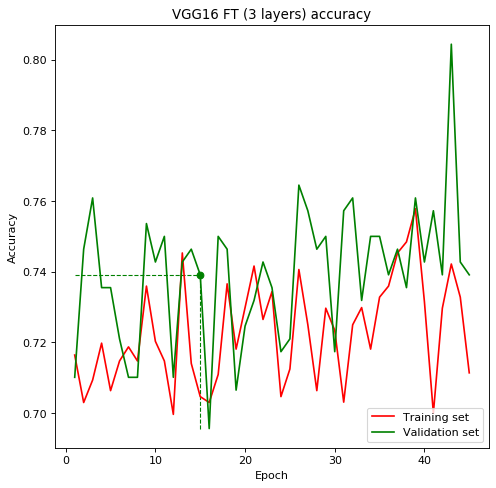

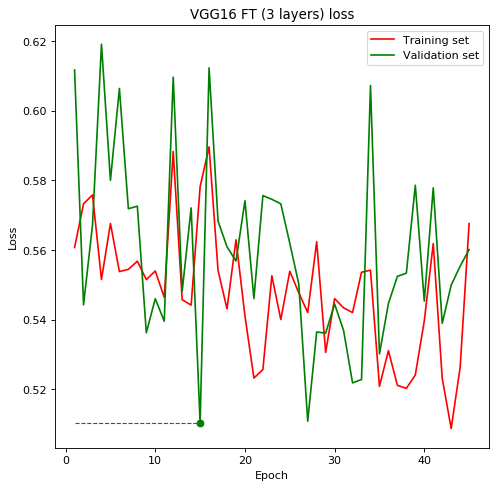

In [32]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();